In [1]:
import os
import glob
import datetime
import numpy as np
import pandas as pd
import xarray as xr

from scipy import stats
from scipy import integrate
from numpy import exp
import math
import pymannkendall as mk

import matplotlib as mpl
import matplotlib.pyplot as plt
### matplotlib setups
## set the line width of the hatch
mpl.rcParams['hatch.linewidth'] = 0.5
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

from osgeo import gdal
#from gistool import rasterize
import pyhdf
from pyhdf.SD import SD

## after arcpy

In [3]:
band1 = xr.open_dataset('MOD15Q2/2022181_mosaic.tif')
x = band1.dims['x']
y = band1.dims['y']
band1

ValueError: did not find a match in any of xarray's currently installed IO backends ['netcdf4', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html

In [3]:
time = np.arange(2022181,2022274,4)

path = 'MOD15Q2/'
filelist = sorted(glob.glob(os.path.join(path, '*.tif')))
lens = len(filelist)


names = locals()
for i in range(0,lens):
    names['band'+str(i)] =xr.open_dataset(filelist[i])
    

arr_s = np.zeros(((1,x,y)))
for i in range(0,lens):
    names['a'+str(i)] = names['band'+str(i)].band_data.values
    arr_s = np.append(arr_s,names['a'+str(i)],axis=0)
arr_s = arr_s[1:,:,:]

dsqc = xr.Dataset({'qc': (['time','lat','lon'], arr_s)},
                      coords={ 'time': (['time'], time),
                               'lat': (['lat'], band1.y.values),
                               'lon': (['lon'], band1.x.values),})



path1 = 'MOD15V2/'
filelist1 = sorted(glob.glob(os.path.join(path1, '*.tif')))
lens1 = len(filelist1)



for i in range(0,lens1):
    names['band'+str(i)] =xr.open_dataset(filelist1[i])
    

arr_s1 = np.zeros(((1,x,y)))
for i in range(0,lens1):
    names['a'+str(i)] = names['band'+str(i)].band_data.values
    arr_s1 = np.append(arr_s1,names['a'+str(i)],axis=0)
arr_s1 = arr_s1[1:,:,:]

dslai = xr.Dataset({'lai': (['time','lat','lon'], arr_s1)},
                      coords={ 'time': (['time'], time),
                               'lat': (['lat'], band1.y.values),
                               'lon': (['lon'], band1.x.values),})

In [5]:
arr_s2 = np.zeros(((1,x,y)))


for t in time:
    # qc1 = dsqc.sel(time=t).qc.values.astype(np.unsignedinteger)
    # qc2 = np.vectorize(np.binary_repr)(qc1[:,:], width=8)
    # qc3 = np.zeros(qc2.shape, dtype=bool)
    # for i in range(0, qc2.shape[0]):
    #     for j in range(0, qc2.shape[1]):
    #         if (qc2[i,j][0:3] == '100' or qc2[i,j][3:5] == '01'):
    #             qc3[i,j] = False
    #         else:
    #             qc3[i,j] = True
    
    
            
    lai1 = dslai.sel(time=t).lai.values.astype(np.unsignedinteger)
    lai3 = np.zeros(lai1.shape)
    for i in range(0, lai1.shape[0]):
        for j in range(0, lai1.shape[1]):
            if (lai1[i,j]<249):
                lai3[i,j] = lai1[i,j] * 0.1
            else:
                lai3[i,j] = np.nan           
    # lai2 = np.zeros(qc2.shape)
    # for i in range(0, qc2.shape[0]):
    #     for j in range(0, qc2.shape[1]):
    #         if (qc3[i,j] == True):
    #             if (lai1[i,j]<249):
    #                 lai2[i,j] = lai1[i,j] * 0.1
    #         else:
    #             lai2[i,j] = np.nan
                
    # reshape lai2 into 3D array
    lai3 = lai3.reshape(1,lai3.shape[0],lai3.shape[1])
    arr_s2 = np.append(arr_s2,lai3,axis=0)


arr_s2 = arr_s2[1:,:,:]
dslai1 = xr.Dataset({'lai': (['time','lat','lon'], arr_s2)},
                    coords={ 'time': (['time'], time),
                            'lat': (['lat'], band1.y.values),
                            'lon': (['lon'], band1.x.values),})

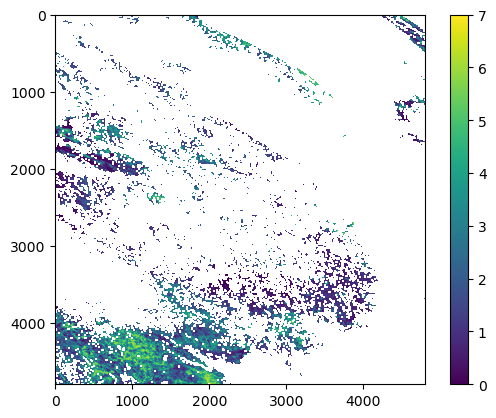

In [7]:
plt.imshow(dslai1.sel(time=2022197).lai.values)
plt.colorbar()

In [6]:
# save dslai1 as netcdf
dslai1.to_netcdf('dslai_nofilter.nc')

In [16]:
dslai1

<xarray.Dataset>
Dimensions:  (time: 24, lat: 4800, lon: 4800)
Coordinates:
  * time     (time) int64 2022181 2022185 2022189 ... 2022265 2022269 2022273
  * lat      (lat) float64 4.448e+06 4.447e+06 4.447e+06 ... 2.225e+06 2.224e+06
  * lon      (lon) float64 1.001e+07 1.001e+07 1.001e+07 ... 1.223e+07 1.223e+07
Data variables:
    lai      (time, lat, lon) float64 1.4 2.0 2.1 2.1 1.5 ... nan nan nan nan

In [2]:
path = 'MOD15/'
filelist = os.listdir(path)
# read the first dataset of hdf file into numpy array
hdf = SD(path+filelist[0])

qc = hdf.select('FparLai_QC')
qc1 = qc[:,:].astype(np.unsignedinteger)
qc2 = np.vectorize(np.binary_repr)(qc1[:,:], width=8)

qc3 = np.zeros(qc2.shape, dtype=bool)
for i in range(0, qc2.shape[0]):
    for j in range(0, qc2.shape[1]):
        if (qc2[i,j][0:3] == '100' or qc2[i,j][3:5] == '01'):
            qc3[i,j] = False
        else:
            qc3[i,j] = True
lai = hdf.select('Lai_500m')
lai1 = lai[:,:].astype(np.unsignedinteger)

lai3 = np.zeros(lai1.shape)
for i in range(0, qc2.shape[0]):
    for j in range(0, qc2.shape[1]):
        if (lai1[i,j]<249):
            lai3[i,j] = lai1[i,j] * 0.1
        else:
            lai3[i,j] = np.nan
            
lai2 = np.zeros(lai1.shape)
for i in range(0, qc2.shape[0]):
    for j in range(0, qc2.shape[1]):
        if (qc3[i,j] == True):
            if (lai1[i,j]<249):
                lai2[i,j] = lai1[i,j] * 0.1
        else:
            lai2[i,j] = np.nan
plt.imshow(lai3)
plt.colorbar()

In [12]:
datasets = gdal.Open(path+filelist[0])
Metadata = datasets.GetMetadata()
Metadata
#  获取四个角的维度
Latitudes = Metadata["GRINGPOINTLATITUDE.1"]
#  采用", "进行分割
LatitudesList = Latitudes.split(", ")
#  获取四个角的经度
Longitude = Metadata["GRINGPOINTLONGITUDE.1"]
#  采用", "进行分割
LongitudeList = Longitude.split(", ")

# 图像四个角的地理坐标
GeoCoordinates = np.zeros((4, 2), dtype = "float32")
GeoCoordinates[0] = np.array([float(LongitudeList[0]),float(LatitudesList[0])])
GeoCoordinates[1] = np.array([float(LongitudeList[1]),float(LatitudesList[1])])
GeoCoordinates[2] = np.array([float(LongitudeList[2]),float(LatitudesList[2])])
GeoCoordinates[3] = np.array([float(LongitudeList[3]),float(LatitudesList[3])])

#  列数
Columns = float(Metadata["DATACOLUMNS500M"])
#  行数
Rows = float(Metadata["DATAROWS500M"])
#  图像四个角的图像坐标
PixelCoordinates = np.array([[0, 0],
                [Columns - 1, 0],
                [Columns - 1, Rows - 1],
                [0, Rows - 1]], dtype = "float32")
#  计算仿射变换矩阵
from scipy.optimize import leastsq
def func(i):
    Transform0, Transform1, Transform2, Transform3, Transform4, Transform5 = i[0], i[1], i[2], i[3], i[4], i[5]
    return [Transform0 + PixelCoordinates[0][0] * Transform1 + PixelCoordinates[0][1] * Transform2 - GeoCoordinates[0][0],
            Transform3 + PixelCoordinates[0][0] * Transform4 + PixelCoordinates[0][1] * Transform5 - GeoCoordinates[0][1],
            Transform0 + PixelCoordinates[1][0] * Transform1 + PixelCoordinates[1][1] * Transform2 - GeoCoordinates[1][0],
            Transform3 + PixelCoordinates[1][0] * Transform4 + PixelCoordinates[1][1] * Transform5 - GeoCoordinates[1][1],
            Transform0 + PixelCoordinates[2][0] * Transform1 + PixelCoordinates[2][1] * Transform2 - GeoCoordinates[2][0],
            Transform3 + PixelCoordinates[2][0] * Transform4 + PixelCoordinates[2][1] * Transform5 - GeoCoordinates[2][1],
            Transform0 + PixelCoordinates[3][0] * Transform1 + PixelCoordinates[3][1] * Transform2 - GeoCoordinates[3][0],
            Transform3 + PixelCoordinates[3][0] * Transform4 + PixelCoordinates[3][1] * Transform5 - GeoCoordinates[3][1]]
#  最小二乘法求解
GeoTransform = leastsq(func,np.asarray((1,1,1,1,1,1)))
print(GeoTransform)
from osgeo import osr
#  获取数据时间
date = '111111'

#  保存为tif
def array2raster(TifName, GeoTransform, array):
    cols = array.shape[1]  # 矩阵列数
    rows = array.shape[0]  # 矩阵行数
    driver = gdal.GetDriverByName('GTiff')
    outRaster = driver.Create(TifName, cols, rows, 1, gdal.GDT_Float32)
    # 括号中两个0表示起始像元的行列号从(0,0)开始
    outRaster.SetGeoTransform(tuple(GeoTransform))
    # 获取数据集第一个波段，是从1开始，不是从0开始
    outband = outRaster.GetRasterBand(1)
    outband.WriteArray(array)
    outRasterSRS = osr.SpatialReference()
    # 代码4326表示WGS84坐标
    outRasterSRS.ImportFromEPSG(4326)
    outRaster.SetProjection(outRasterSRS.ExportToWkt())
    outband.FlushCache()

TifName = date + ".tif"
array2raster(TifName, GeoTransform[0], lai1)

## after nc file

In [2]:
ds0 = xr.open_dataset('/portal1/dell/li-b/MODIS1/ET.nc')
ds0

<xarray.Dataset>
Dimensions:     (time: 1013, lat: 2425, lon: 4441)
Coordinates:
  * time        (time) object 2000-12-26 00:00:00 ... 2022-12-27 00:00:00
  * lat         (lat) float64 34.6 34.6 34.59 34.59 ... 24.51 24.51 24.51 24.5
  * lon         (lon) float64 103.5 103.5 103.5 103.5 ... 122.0 122.0 122.0
Data variables:
    crs         int8 ...
    ET_500m     (time, lat, lon) float32 ...
    ET_QC_500m  (time, lat, lon) float32 ...
Attributes:
    title:        MOD16A2GF.061 for aid0001
    Conventions:  CF-1.6
    institution:  Land Processes Distributed Active Archive Center (LP DAAC)
    source:       AppEEARS v3.39
    references:   See README.md
    history:      See README.md

In [7]:
times = ds0['time'].values
vari = ds0['ET_500m'].sel(lon=slice(110.504167,122.004167), lat=slice(34.004167,24.504167), time=slice(times[701],times[1012])).to_dataset(name='vari')
qc = ds0['ET_QC_500m'].sel(lon=slice(110.504167,122.004167), lat=slice(34.004167,24.504167), time=slice(times[701],times[1012])).to_dataset(name='qc')

In [8]:
times1 = vari.time.values
x = vari.dims['lon']
y = vari.dims['lat']

In [9]:
arr_s0 = np.zeros(((1,y,x)))

for t in times1:
    print(t, end='\r')
    qc_a = qc.sel(time=t).qc.values
    
    
    qc_b = np.zeros((y, x), dtype=bool)
    
    #qc_b = (np.bitwise_and(qc_a.astype(np.uint8), 0b11100000) != 128) & (np.bitwise_and(qc_a.astype(np.uint8), 0b00011000) != 8)
    qc_b = np.bitwise_and(qc_a.astype(np.uint8), 0b00011000) != 8

    
    vari_a = vari.sel(time=t).vari.values
    vari_b = np.zeros((y, x))

    vari_b = np.where(qc_b & (vari_a<3270), vari_a, np.nan)

              
    vari_c = vari_b.reshape(1,y,x)
    
    arr_s0 = np.append(arr_s0,vari_c,axis=0)
    
    
arr_s1 = arr_s0[1:,:,:]

/tmp/ipykernel_40368/895194508.py:11: RuntimeWarning: invalid value encountered in cast
  qc_b = np.bitwise_and(qc_a.astype(np.uint8), 0b00011000) != 8


In [10]:
dsvari1 = xr.Dataset({'vari': (['time','lat','lon'], arr_s1)},
                    coords={ 'time': (['time'], vari.time.values),
                            'lat': (['lat'], vari.lat.values),
                            'lon': (['lon'], vari.lon.values),})
dsvari1.to_netcdf('/portal1/dell/li-b/MODIS1/ET_qc2.nc')